In [1]:
import json

with open('/data/jiwoong/retriever/articles/pubmed/PubMed_Articles_35.json', 'r') as jsfile:
    PubMed_Articles_35 = json.load(jsfile)

In [3]:
PubMed_Articles_35[0]

'Hypusinated EIF5A as a feasible drug target for Advanced Medicinal Therapies in the treatment of pathogenic parasites and therapy-resistant tumors. Cancer drug resistance, in particular in advanced stages such as metastasis and invasion is an emerging problem. Moreover, drug resistance of parasites causing poverty-related diseases is an enormous, global challenge for drug development in the future. To circumvent this problem of increasing resistance, the development of either novel small compounds or Advanced Medicinal Therapies have to be fostered. Polyamines have many fundamental cellular functions like DNA stabilization, protein translation, ion channel regulation, autophagy, apoptosis and mostly important, cell proliferation. Consequently, many antiproliferative drugs can be commonly administered either in cancer therapy or for the treatment of pathogenic parasites. Most important for cell proliferation is the triamine spermidine, since'

In [5]:
# Sample code to calculate stats for lengths and print the top 5 longest strings in a list

def analyze_string_lengths(string_list):
    # Calculate length for each string
    lengths = [len(s) for s in string_list]
    
    # Calculate basic statistics
    min_length = min(lengths)
    max_length = max(lengths)
    avg_length = sum(lengths) / len(lengths)
    
    # Sort strings by length and get top 5 longest
    top_5_longest = sorted(string_list, key=len, reverse=True)[:5]
    
    # Print stats and top 5 longest strings
    stats = {
        "min_length": min_length,
        "max_length": max_length,
        "avg_length": avg_length,
        "top_5_longest": top_5_longest
    }
    return stats, top_5_longest

a, b= analyze_string_lengths(PubMed_Articles_35)

'of the 100 patients, 16 were in high risk, 68 in intermediate risk and 16 in low risk group. <br> There was a difference in HbA1c between the three OSAgroups indicating poorer glycemic control in high risk group which was statistically significant (p=0.04). <br> It was seen that mean hsCRP was higher in high risk group for OSA compared to other two groups indicating higher grade of inflammation in the high risk group. There was a statistically significant correlation between STOP BANG score [indicating OSA risk] and hsCRP(r=0.25,p=0.012) and STOP BANG SCORE and microvascular complications -Toronto neuropathy score [for diabetic neuropathy] (r=0.346,p=0.0004), UMCR [for diabetic nephropathy] (r=0.44,p=0.00001) and presence and absence of diabetic retinopathy(r=0.35,p=0.003). <b style="font-size: 1rem;">Conclusion: <span style="font-size: 1rem;">All'
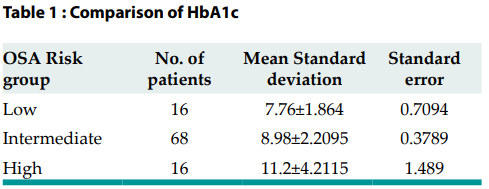
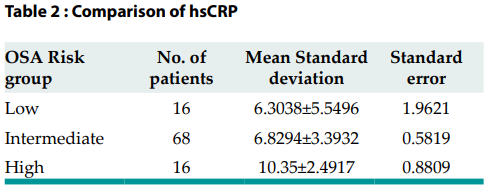

In [16]:
b[0]

In [ ]:
import time
from typing import List, Dict, Any
from openai import AzureOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
import utils
from pymilvus import MilvusClient, DataType

retrieval_client = MilvusClient(
    uri="http://localhost:19530"
)

llm_client = AzureOpenAI(
    azure_endpoint = "https://azure-openai-miblab-ncu.openai.azure.com/",
    api_key = "9a8467bfe81d443d97b1af452662c33c",
    api_version = "2024-08-01-preview",
)

class CIDER:
    def __init__(self, model="gpt-4o-mini"):

        self.model = model
        self.current_knowledge = []
        self.iteration_history = []
        self.expert_roles = []
        
    def process_query(self, initial_query: str) -> Dict[str, Any]:
        iteration = 0
        consensus_reached = False
        
        while not consensus_reached:
            print(f"Starting iteration {iteration}")
            
            # 0. Domain Expert Generation
            expert_roles = self._generate_expert_domains(initial_query)

            # 1. Query Generation
            queries = self._generate_expert_query(initial_query)
            
            # 2. Document Retrieval
            retrieved_docs = []
            for query in expert_queries:
                docs = utils.retrieve(query)
                docs = utils.rerank(query, docs)
                retrieved_docs.extend(docs)
            
            # 3. Expert Analysis
            expert_analyses = self._expert_analysis(retrieved_docs)
            
            # 4. Consensus Check
            consensus_result = self._check_consensus(expert_analyses)
            consensus_reached = consensus_result['consensus_reached']
            
            # 5. Record Iteration
            self.iteration_history.append({
                'iteration': iteration,
                'queries': expert_queries,
                'docs': retrieved_docs,
                'analyses': expert_analyses,
                'consensus': consensus_result
            })
            
            # 6. Update Knowledge
            self.current_knowledge.extend(retrieved_docs)
            
            iteration += 1
            
        return self._generate_final_report()

    def _generate_expert_domains(self, query: str) -> List[str]:
       domain_prompt = """Given the medical query below, identify most relevant medical specialties needed for comprehensive analysis.
    
       Query: {query}
    
       List only the specialties, one per line."""
    
       messages = [
           {"role": "system", "content": "You are a medical domain expert selector."},
           {"role": "user", "content": domain_prompt.format(query=query)}
       ]
    
       try:
           response = self._call_llm(messages)
           domains = [domain.strip() for domain in response.split('\n') if domain.strip()]

           # Generate expert roles for each domain
           expert_roles = []
           for domain in domains:
               role = f"""You are a medical expert specialized in {domain}. 
               Analyze information through the lens of your specialty.
               Focus on aspects relevant to {domain}.
               Identify gaps in domain-specific knowledge."""
               expert_roles.append(role)

           return expert_roles

       except Exception as e:
           print(f"Error generating expert domains: {str(e)}")
           # Fallback to core specialties
           return [
               "You are an internal medicine specialist focusing on overall case integration.",
               "You are a diagnostic specialist focusing on differential diagnosis.",
               "You are a clinical specialist focusing on treatment approaches."
           ]


    def _generate_expert_query(self, context: str) -> List[str]:
        all_queries = []

        query_prompt = """Analyze the medical context and generate a snippet of medical document to fill knowledge gaps.

    Context: {context}
    Knowledge Gaps: {gaps}

    Instructions:
    - Generate one specific medical document addressing the knowledge gaps
    - Focus on gathering concrete, clinically relevant information
    - Ensure each query is distinct and detailed

    Queries:"""

        for role in expert_roles:
            messages = [
                {"role": "system", "content": f"You are a medical expert specialized in the {op_domain} domain generating clinically relevant documents."},
                {"role": "user", "content": query_prompt.format(
                    context=context,
                    gaps=self._identify_knowledge_gaps()
                )}
            ]

            try:
                response = self._call_llm(messages)
                queries = response.split["Queries:"][-1]
                all_queries.extend(queries)
            except Exception as e:
                print(f"Error generating queries for role {role}: {str(e)}")
                continue
        return list(all_queries)

    def _expert_analysis(self, documents, context) -> List[Dict]:
       analyses = []
    
       analysis_prompt = """Given the medical context below, analyze the following documents based on your expertise.
    
       Original Context:
       {context}

       Retrieved Documents:
       {docs}
    
       Provide your analysis in the following format:
       1. Key Findings (specifically relating to the original query):
       2. Remaining Questions (what else do we need to know to fully address the query):
       3. Is the information sufficient to answer the original query? (yes/no)
       4. Explain your reasoning for why the information is or isn't sufficient."""
    
       for role in expert_roles:
           messages = [
               {"role": "system", "content": role},
               {"role": "user", "content": analysis_prompt.format(
                   context=query_context,
                   docs=self._format_docs_for_prompt(documents)
               )}
           ]

           response = self._call_llm(messages)
           analyses.append({
               'role': role,
               'analysis': response
           })

       return analyses

    def _check_consensus(self, expert_analyses: List[Dict]) -> Dict[str, Any]:
        consensus_prompt = """Review the analyses from all experts and determine if consensus has been reached.
        
        Expert Analyses:
        {analyses}
        
        Determine:
        1. Is there consensus? (yes/no)
        2. What are the remaining disagreements?
        3. What additional information is needed?"""
        
        messages = [
            {"role": "system", "content": "You are a medical consensus evaluator."},
            {"role": "user", "content": consensus_prompt.format(
                analyses=self._format_analyses_for_prompt(expert_analyses)
            )}
        ]
        
        response = self._call_llm(messages)
        
        # Parse response to determine consensus
        consensus_reached = 'yes' in response.lower().split('\n')[0]
        
        return {
            'consensus_reached': consensus_reached,
            'full_evaluation': response
        }

    def _call_llm(self, messages: List[Dict]) -> str:
        response = llm_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=0,
            max_tokens=1000
        )
        return response.choices[0].message.content

    def _identify_knowledge_gaps(self) -> str:
        """Identify current knowledge gaps from iteration history."""
        if not self.iteration_history:
            return "Initial query - no current gaps identified"
            
        last_iteration = self.iteration_history[-1]
        gaps = []
        
        for analysis in last_iteration['analyses']:
            if 'Remaining Questions' in analysis['analysis']:
                questions = analysis['analysis'].split('Remaining Questions:')[1].split('\n')
                gaps.extend([q.strip() for q in questions if q.strip()])
                
        return '\n'.join(gaps)

    def _format_docs_for_prompt(self, docs) -> str:
#        formatted_docs = []
#        for i, doc in enumerate(docs[:], 1):
#            formatted_docs.append(f"Document {i}:\n{doc['content'][:500]}...")
        return '\n'.join(docs)

    def _format_analyses_for_prompt(self, analyses: List[Dict]) -> str:
        formatted = []
        for analysis in analyses:
            formatted.append(f"Expert ({analysis['role']}):\n{analysis['analysis']}")
        return '\n\n'.join(formatted)

    def _generate_final_report(self) -> Dict[str, Any]:
        """Generate final report with findings and metadata."""
        report_prompt = """Generate a final medical report based on all gathered information.
        
        Iteration History:
        {history}
        
        Format the report with:
        1. Key Findings
        2. Recommendations
        3. Confidence Level
        4. References to Key Documents"""
        
        messages = [
            {"role": "system", "content": "You are a medical report synthesizer."},
            {"role": "user", "content": report_prompt.format(
                history=self._format_history_for_prompt()
            )}
        ]
        
        report = self._call_llm(messages)
        
        return {
            'report': report,
            'iterations': len(self.iteration_history),
            'total_documents': len(self.current_knowledge)
        }

    def _format_history_for_prompt(self) -> str:
        """Format iteration history for final report."""
        formatted = []
        for iteration in self.iteration_history:
            formatted.append(f"""
            Iteration {iteration['iteration']}:
            - Queries Asked: {len(iteration['queries'])}
            - Documents Retrieved: {len(iteration['docs'])}
            - Expert Analyses: {len(iteration['analyses'])}
            """)
        return '\n'.join(formatted)